In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid

In [3]:
def plot_data(data_dict, ax=None):
    cmap = "coolwarm"
    od_color = "black"

    # Use the provided ax or create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    # Plot anchor points colored by class labels
    if "anchor" in data_dict:
        anchor_X, anchor_y = data_dict["anchor"]
        ax.scatter(anchor_X[:, 0], anchor_X[:, 1], c=anchor_y, cmap=cmap, label="Anchor")

    if "ID" in data_dict:
        id_X, id_y = data_dict["ID"]
        # Plot in-distribution (ID) data points with lighter color
        ax.scatter(id_X[:, 0], id_X[:, 1], c=id_y, cmap=cmap, alpha=0.5, label="In-Distribution")

    if "OD" in data_dict:
        od_X, od_y = data_dict["OD"]
        # Plot OD data points with distinct color
        ax.scatter(od_X[:, 0], od_X[:, 1], c=od_color, label="Out-of-Distribution")

    ax.legend()

    # Only call plt.show() if ax was not provided
    if ax is None:
        plt.show()

In [4]:
@torch.inference_mode()
def contrastive_transform(net, task, X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(net.device)
    return net.contrastive_embedding(X, task).detach().cpu().numpy()

In [5]:
def apply_transform_to_data_dict(data_dict, transform=None):
    """
    Applies a transformation function to the X component of each dataset in the data_dict.

    :param data_dict: Dictionary containing datasets. Each key corresponds to a dataset name,
                      and each value is a tuple (X, y) where X is the data to transform.
    :param transform: A function that applies a transformation to X.
    :return: A new data_dict with transformed X components.
    """
    transformed_data_dict = {}
    if transform is None:
        transform = lambda x: x

    for key, (X, y) in data_dict.items():
        # Apply the transform function to X
        transformed_X = transform(X)

        # Update the dataset in the new dictionary
        transformed_data_dict[key] = (transformed_X, y)

    return transformed_data_dict

In [6]:
def combined_tsne_transform(data_dict, n_components=2, random_state=42):
    """
    Applies t-SNE to reduce the dimensions of the combined image data from all subsets
    (OD, ID, anchor) to ensure they are mapped to the same space.

    :param data_dict: Dictionary containing OD, ID, and anchor datasets.
                      Each value should be a tuple (X, y).
    :param n_components: The number of dimensions to reduce to (default is 2).
    :param random_state: Random state for reproducibility (optional).
    :return: Dictionary with transformed data for each subset.
    """
    # Combine all subsets into one dataset for fitting t-SNE
    combined_X = np.concatenate([X.reshape(X.shape[0], -1) for X, _ in data_dict.values()], axis=0)

    # Fit t-SNE on the combined dataset
    tsne = TSNE(n_components=n_components, random_state=random_state)
    combined_X_transformed = tsne.fit_transform(combined_X)

    # Split the transformed data back into the respective subsets
    transformed_data_dict = {}
    start_idx = 0
    for key, (X, y) in data_dict.items():
        end_idx = start_idx + X.shape[0]
        transformed_data_dict[key] = (combined_X_transformed[start_idx:end_idx, :], y)
        start_idx = end_idx

    return transformed_data_dict

In [7]:
def plot_scores(data_dict, computer, ax=None):
    """
    Produces a histogram plot for the given data_dict, showing the distribution of scores.
    :param data_dict: Dictionary with keys 'anchor', 'ID', and 'OD'.
    :param computer: Function that computes the scores.
    :param ax: Optional matplotlib axes object.
    """
    scores_dict = {}

    # Compute scores
    for key in ['anchor', 'ID', 'OD']:
        if key in data_dict:
            X, y = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores

    colors = {'anchor': 'blue', 'ID': 'green', 'OD': 'red'}
    all_scores = np.concatenate([scores for scores in scores_dict.values()])

    # Determine bins
    bins = np.linspace(all_scores.min(), all_scores.max(), 30)

    # Create plot
    if ax is None:
        ax = plt.gca()
    for key, scores in scores_dict.items():
        ax.hist(scores, bins=bins, alpha=0.5, label=key, color=colors.get(key, 'black'))

    ax.set_xlabel('Scores')
    ax.set_ylabel('Frequency')
    ax.set_title('Score Distributions by Data Category')
    ax.legend()
    # return scores_dict

In [8]:
# @torch.inference_mode()
# def prefilter_computer(net, X, task_id, computer_type):
#     """
#     NOTE: these are based on the classifier. TODO: try based on the contrastive embedding.
#     """
#     if isinstance(X, np.ndarray):
#         X = torch.from_numpy(X)

#     print(X.shape)
#     logits = net(X.to(net.device), task_id)
#     if computer_type == "cross_entropy":
#         scores = entropy_scorer(logits)
#     elif computer_type == "least_confidence":
#         scores = least_confidence_scorer(logits)
#     elif computer_type == "margin":
#         scores = margin_scorer(logits)
#     elif computer_type == "random":
#         scores = random_scorer(logits)
#     else:
#         raise NotImplementedError

#     return scores.detach().cpu().numpy()

In [9]:
# @torch.inference_mode()
# def knn_distance(net, task_id, anchor, X, exclude_self=True):
#     anchor_embed = contrastive_transform(net, task_id, anchor_X)
#     X_embed = contrastive_transform(net, task_id, X)
#     # anchor_embed.shape = (N, F) and X_embed.shape = (M, F)
#     # where N = len(anchor_X) and M = len(X), and F is the embedding dimension
#     # return X_dist.shape = len(X) where each element is the distance to the nearest anchor
#     # X_embed and anchor_embed are np arrays
#     # taking min excludes the anchor itself (distance = 0)



@torch.inference_mode()
def knn_distance(net, task_id, anchor_X, X, exclude_self=True):
    anchor_embed = contrastive_transform(net, task_id, anchor_X)
    X_embed = contrastive_transform(net, task_id, X)

    # Compute pairwise distances using broadcasting
    distances = np.linalg.norm(X_embed[:, np.newaxis] - anchor_embed, axis=2)

    if exclude_self:
        # Create a mask where each element compares X_embed to each anchor_embed
        # The mask is True where embeddings are equal
        mask = np.all(np.isclose(X_embed[:, np.newaxis], anchor_embed), axis=2)
        
        # Set distances to infinity where the mask is True
        distances[mask] = np.inf

    # Find the minimum distance for each element in X_embed
    min_distances = np.min(distances, axis=1)

    return min_distances

In [10]:
def save_debug_data(fleet):
    for agent in fleet.agents:
        agent.save_debug_data()


def load_debug_data(fleet):
    for agent in fleet.agents:
        agent.load_debug_data()


dataset = "mnist"
algo = "modular"
prefilter_strategy = "None"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = None  # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 5,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
})

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}
i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_

In [11]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

In [12]:
task_id = 4

# fleet.load_model_from_ckpoint(task_ids=task_id)
fleet.update_replay_buffers(task_id)

In [13]:
agent = fleet.agents[0]
X_od, y_od, X_id, y_id = agent.get_ood_data(task_id)
X_od.shape, y_od.shape

(torch.Size([110, 1, 28, 28]), torch.Size([110]))

In [14]:
agent.eval_test(task_id)

{0: 0.5235042735042735,
 1: 0.5070281124497992,
 2: 0.49381443298969074,
 3: 0.5070281124497992,
 4: 0.4984646878198567,
 'avg': 0.505967923842684}

In [15]:
agent.net.structure[task_id]

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], device='cuda:0', requires_grad=True)

In [16]:
agent.net.components[0].bias

Parameter containing:
tensor([ 0.1057, -0.0383,  0.0160,  0.0921,  0.0806,  0.0830, -0.0389,  0.0411,
         0.0690, -0.0742, -0.0780,  0.0554, -0.1207, -0.0566, -0.1030, -0.0669,
         0.0305, -0.0217, -0.0294,  0.0738, -0.1012, -0.0813,  0.0688, -0.0307,
         0.0770,  0.0428,  0.0303, -0.0631,  0.0112,  0.0723, -0.1248, -0.0840,
         0.0705, -0.0221,  0.0225,  0.0244, -0.0595,  0.1172, -0.0036,  0.1025,
         0.0318, -0.0712, -0.0257,  0.1050,  0.1234, -0.0635, -0.0276, -0.0404,
         0.1003, -0.0206, -0.0304,  0.1175,  0.1203,  0.0476,  0.0308,  0.0342,
        -0.0470,  0.0182,  0.0923, -0.0314, -0.0846,  0.0844,  0.0833, -0.1087],
       device='cuda:0', requires_grad=True)

In [17]:
agent.net.decoder[task_id].bias

Parameter containing:
tensor([0.0870, 0.0657], device='cuda:0', requires_grad=True)

In [18]:
anchor_X, anchor_y, _ = agent.agent.replay_buffers[task_id].tensors
anchor_y = get_global_labels(anchor_y, task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)

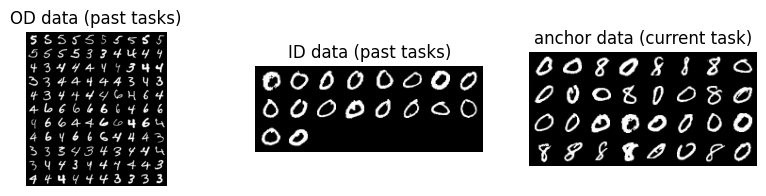

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
axes[0].imshow(make_grid(X_od, nrow=10).permute(1,2,0))
axes[0].set_title("OD data (past tasks)")
axes[0].axis("off")

axes[1].imshow(make_grid(X_id, n_rows=10).permute(1,2,0))
axes[1].set_title("ID data (past tasks)");
axes[1].axis("off")


axes[2].imshow(make_grid(anchor_X, n_rows=10).permute(1,2,0))
axes[2].set_title("anchor data (current task)");
axes[2].axis("off");

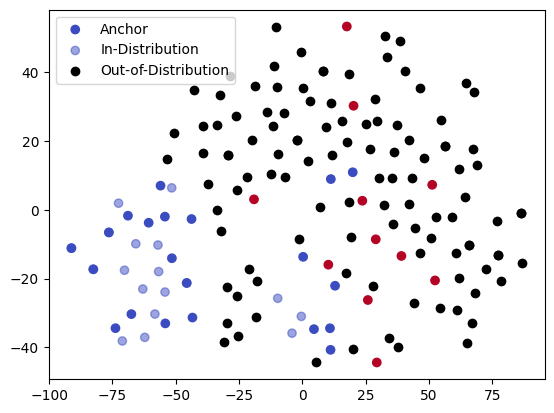

In [20]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

# Partial function for transform
transform = partial(contrastive_transform, agent.net, task_id)

# Process and plot data with OD
data_dict = apply_transform_to_data_dict(data_dict, transform)
data_dict = combined_tsne_transform(data_dict)
plot_data(data_dict)

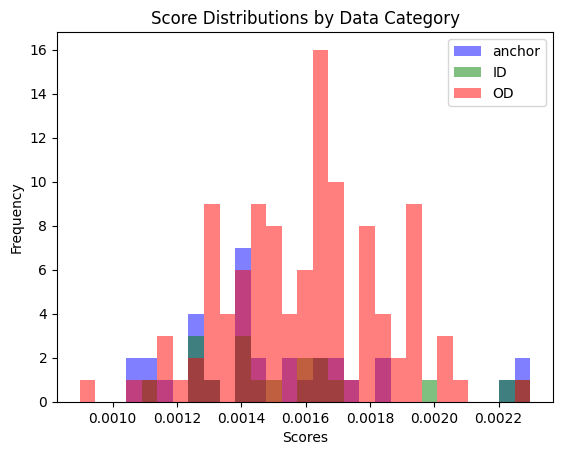

In [21]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

computer = partial(knn_distance, agent.net, task_id, anchor_X)
plot_scores(data_dict, computer)

In [22]:
# cp_data_dict = deepcopy(data_dict)
# del cp_data_dict["OD"]
# plot_data(cp_data_dict)

In [23]:
import itertools
from torch.utils.data import Dataset, DataLoader

class TaskAndOODDataset(Dataset):
    def __init__(self, X_task, X_task_aug, y_task, X_ood):
        """
        Custom dataset to contain both task data (with labels and augmented data) and OOD data.
        """
        self.X_task = X_task
        self.X_task_aug = X_task_aug
        self.y_task = y_task
        self.X_ood = X_ood

        # Create iterators for task data and OOD data
        self.task_iterator = itertools.cycle(zip(X_task, X_task_aug, y_task))
        self.ood_iterator = itertools.cycle(X_ood)

        # Determine the length of the dataset as the maximum of both lengths
        self.length = max(len(X_task), len(X_ood))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Get next item from each iterator
        X_task_item, X_task_aug_item, y_task_item = next(self.task_iterator)
        X_ood_item = next(self.ood_iterator)

        return X_task_item, X_task_aug_item, y_task_item, X_ood_item

# Usage
# anchor_X, anchor_y, _ = agent.agent.replay_buffers[task_id].tensors
anchor_X, anchor_y = agent.dataset.trainset[task_id].tensors
anchor_X_aug, *_ = agent.agent.aug_replay_buffers[task_id].tensors
X_ood, *_ = agent.get_ood_data(task_id)

task_and_ood_dataset = TaskAndOODDataset(anchor_X, anchor_X_aug, anchor_y, X_ood)

# Create the DataLoader
batch_size = 64 # Adjust the batch size as per your requirement
train_loader = DataLoader(task_and_ood_dataset, batch_size=batch_size, shuffle=True)


In [24]:
agent.dataset.trainset[task_id]

In [25]:
# trainloader = (
#             torch.utils.data.DataLoader(agent.dataset.trainset[task_id],
#                                         batch_size=batch_size,
#                                         shuffle=True,
#                                         num_workers=4,
#                                         pin_memory=True,
#                                         ))

In [26]:
# oodloss = OODSeparationLoss(lambda_ood=20., delta=2.0)
# oodloss = OODSeparationLoss(lambda_ood=20., delta=1.0)
oodloss = OODSeparationLoss(lambda_ood=10., delta=1.0)
# oodloss = OODSeparationLoss(lambda_ood=0., delta=1.0)
# oodloss = OODSeparationLoss()

# num_epochs = 15
num_epochs = 100
od_losses = []
cl_losses = []
losses = []

net = agent.net

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

lambdas = []
for i in range(num_epochs):
    lambdas.append(oodloss.lambda_ood)
    for batch in train_loader:
        X, X_aug, y, X_ood = batch
        X = X.to(net.device)
        X_ood = X_ood.to(net.device)
        y = y.to(net.device)
        X_aug = X_aug.to(net.device)
        X_combined = torch.cat([X, X_aug], dim=0)

        task_embeddings = net.contrastive_embedding(X, task_id)
        ood_embeddings = net.contrastive_embedding(X_ood, task_id)

        loss = oodloss(task_embeddings, ood_embeddings)
        od_losses.append(loss.item())

        # cl = agent.agent.compute_contrastive_loss(X_combined, y, task_id)
        # loss = 0.
        # print(len(batch))
        # X, X_aug, y = batch
        # X_combined = torch.cat([X, X_aug], dim=0)
        cl = agent.agent.compute_task_loss(X_combined, y, task_id) # entropy and contrastive loss
        cl_losses.append(cl.item())
        loss += cl
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    # regularly decay lambda_ood to focus more on contrastive loss
    if i % 10 == 0:
        oodloss.lambda_ood *= 0.9

In [27]:
batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape

(torch.Size([64, 1, 28, 28]),
 torch.Size([64, 1, 28, 28]),
 torch.Size([64]),
 torch.Size([64, 1, 28, 28]))

In [28]:
agent.net.structure[task_id]

Parameter containing:
tensor([[1.0846, 1.1256, 0.9695, 1.0248],
        [0.9711, 1.0014, 0.9574, 0.9144],
        [0.9826, 0.9817, 1.1026, 1.0859],
        [1.0070, 0.9439, 0.9253, 0.9492]], device='cuda:0', requires_grad=True)

In [29]:
agent.net.components[0].bias

Parameter containing:
tensor([ 0.0962,  0.0148,  0.1145,  0.2006,  0.1428,  0.1583, -0.0676,  0.1085,
         0.0931, -0.0425, -0.0701,  0.1016, -0.0734, -0.0182, -0.1315,  0.0059,
         0.0795,  0.0515,  0.0040,  0.1691, -0.1566, -0.0586,  0.0804,  0.0103,
         0.1324,  0.0901,  0.0393,  0.0051,  0.0822,  0.0657, -0.1204,  0.0012,
         0.0558, -0.0184,  0.1252,  0.0468, -0.0629,  0.0987,  0.0309,  0.1812,
         0.0967, -0.0550, -0.0151,  0.1692,  0.2268, -0.0126,  0.0227,  0.0190,
         0.1830,  0.0075, -0.0189,  0.0657,  0.1781,  0.0886,  0.0978,  0.1014,
        -0.0304,  0.0767,  0.1459, -0.1259, -0.1081,  0.1415,  0.1600, -0.0684],
       device='cuda:0', requires_grad=True)

In [30]:
agent.net.decoder[task_id].bias

Parameter containing:
tensor([0.1399, 0.0129], device='cuda:0', requires_grad=True)

In [31]:
agent.eval_test(task_id)

{0: 0.6901709401709402,
 1: 0.5145582329317269,
 2: 0.49381443298969074,
 3: 0.4352409638554217,
 4: 0.8930399181166837,
 'avg': 0.6053648976128926}

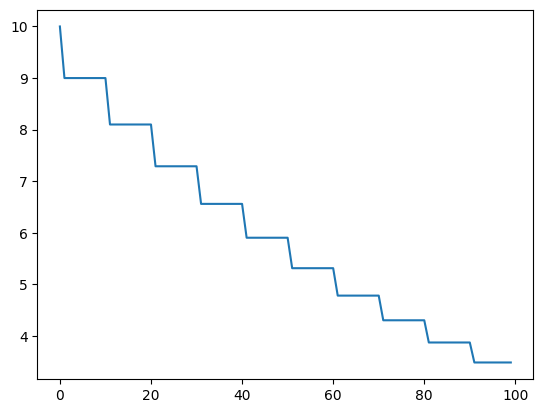

In [32]:
plt.plot(lambdas);

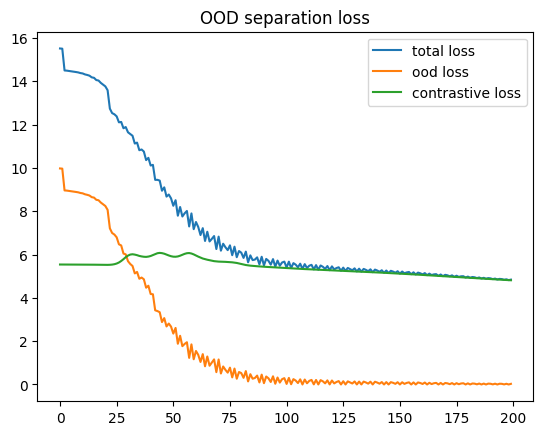

In [33]:
plt.plot(losses, label="total loss")
plt.plot(od_losses, label="ood loss")
plt.plot(cl_losses, label="contrastive loss")
plt.legend()
plt.title("OOD separation loss");

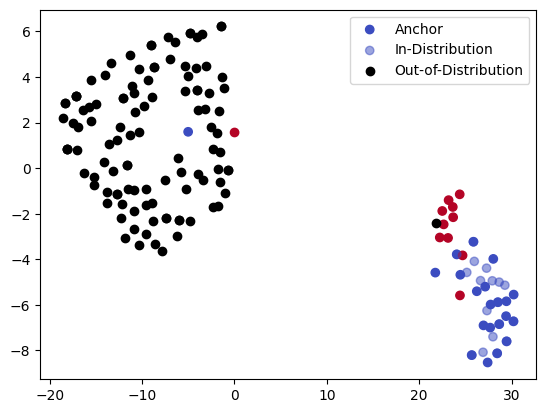

In [34]:
anchor_X, anchor_y, _ = agent.agent.replay_buffers[task_id].tensors
anchor_y = get_global_labels(anchor_y, task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

# del data_dict['OD']
# Partial function for transform
transform = partial(contrastive_transform, agent.net, task_id)

# Process and plot data with OD
data_dict = apply_transform_to_data_dict(data_dict, transform)
data_dict = combined_tsne_transform(data_dict)
plot_data(data_dict)

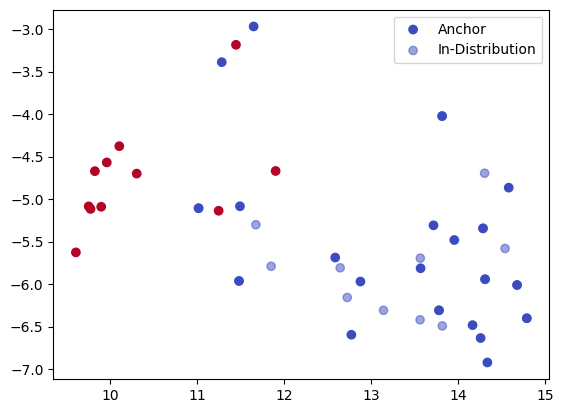

In [35]:
anchor_X, anchor_y, _ = agent.agent.replay_buffers[task_id].tensors
anchor_y = get_global_labels(anchor_y, task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
data_dict = {
    "anchor": (anchor_X, anchor_y),
    # "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

# del data_dict['OD']
# Partial function for transform
transform = partial(contrastive_transform, agent.net, task_id)

# Process and plot data with OD
data_dict = apply_transform_to_data_dict(data_dict, transform)
data_dict = combined_tsne_transform(data_dict)
plot_data(data_dict)

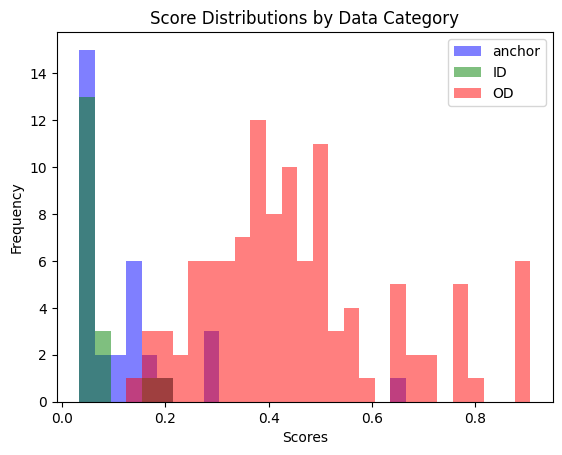

In [36]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

computer = partial(knn_distance, agent.net, task_id, anchor_X)
plot_scores(data_dict, computer)